In [1]:
#LSTM caso 1: MULTIVADIADO - MULTISTEP

#Obtencion de la data y procesados de datos
import pyodbc
import os
import pandas as pd
from datetime import date, datetime, timedelta
import numpy as np
from sklearn.ensemble import IsolationForest

#Gráfios
import matplotlib.pylab as plt
%matplotlib inline
from skforecast.plot import set_dark_theme
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)

# Keras
# ==============================================================================
os.environ["KERAS_BACKEND"] = "tensorflow" # 'tensorflow', 'jax´ or 'torch'
import keras
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.callbacks import EarlyStopping

if keras.__version__ > "3.0":
    if keras.backend.backend() == "tensorflow":
        import tensorflow
    elif keras.backend.backend() == "torch":
        import torch
    else:
        print("Backend not recognized. Please use 'tensorflow' or 'torch'.")

# Modelado 
# ==============================================================================
import skforecast
from skforecast.deep_learning import ForecasterRnn
from skforecast.deep_learning.utils import create_and_compile_model
from sklearn.preprocessing import MinMaxScaler
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_forecaster_multiseries

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('once')

color = '\033[1m\033[38;5;208m' 
print(f"{color}Version skforecast: {skforecast.__version__}")
print(f"{color}Version Keras: {keras.__version__}")
print(f"{color}Using backend: {keras.backend.backend()}")
print(f"{color}Version pandas: {pd.__version__}")
print(f"{color}Version numpy: {np.__version__}")
if keras.__version__ > "3.0":
    if keras.backend.backend() == "tensorflow":
        print(f"{color}Version tensorflow: {tensorflow.__version__}")
    elif keras.backend.backend() == "torch":
        print(f"{color}Version torch: {torch.__version__}")
    else:
        print(f"{color}Version torch: {jax.__version__}")

c:\GitHub\pronostico\pronostico\envprediccion\Lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



Version skforecast: 0.16.0
Version Keras: 3.8.0
Using backend: tensorflow
Version pandas: 2.2.3
Version numpy: 2.0.2
Version tensorflow: 2.18.0


# Preparación de la data
Haremos una consulta hacia la base de datos para extraer toda la data histórica

In [ ]:
def get_sqlconnection(config_sqlServer):
    status = "inicializando...."
    try: 
        connection = pyodbc.connect(config_sqlServer)
        status = "Conexion establecida satisfactoriamente"
    except Exception as e:
        status = "Error al establecer la conexión:"+e
    print(status)
    return connection

In [3]:
def set_index_datetime(data):
        if str(type(data) == "<class 'pandas.core.frame.DataFrame'>"):
            # data.sort_values('fecha', inplace=True)
            for column in data.columns: 
                try: 
                    pd.to_datetime(data[column])
                    data.set_index(column,inplace=True)
                    return data
                except Exception as e:  
                    pass
        else: 
            return 0

* Consultas

In [4]:
# parámetros de conexión
sql_server = """
DRIVER={ODBC Driver 17 for SQL Server};
server=US3RN4M3;
database=AdventureWorksDW2022;
Trusted_connection=yes;
"""

In [5]:
# Consulta 1 para obtener la data histórica con las features 
query = """
SELECT
    CAST(OrderDate AS DATE) AS Date
    ,YEAR([OrderDate]) AS [YEAR]
    ,MONTH([OrderDate]) AS [MONTH]
    ,DAY([OrderDate]) AS [Day]
    ,DATEPART(weekday, [OrderDate]) - 1 AS [DayOfWeek]
    ,CASE
        WHEN DATEPART(weekday, [OrderDate]) IN (7, 1) THEN 1
        ELSE 0
    END AS IsWeekend
    ,[ProductKey]
    ,Sum([OrderQuantity]) AS OrderQuantity
    ,Sum([UnitPrice]) AS UnitPrice
    ,Sum([UnitPriceDiscountPct]) As UnitPriceDiscountPct
    ,Sum([DiscountAmount]) AS DiscountAmount
    ,Sum([ProductStandardCost]) AS ProductStandardCost
    ,Sum([SalesAmount]) AS SalesAmount
    FROM [AdventureWorksDW2022].[dbo].[FactInternetSales]
    WHERE
    [FactInternetSales].OrderDate < '2013-12-01'
    group by YEAR([OrderDate]),MONTH([OrderDate]),DAY([OrderDate]),DATENAME(weekday,[OrderDate]),[OrderDate],[ProductKey]
    order by YEAR([OrderDate]) ASC,MONTH([OrderDate]) ASC,DAY([OrderDate]) ASC
"""

In [6]:
# Consulta 2 para obtener la data de historica de ventas en general diarias de un producto x
query2 = """
SELECT 
    CAST(f.OrderDate AS DATE) AS sales_date,
    CAST(SUM(f.OrderQuantity) AS INT) AS TotalVentas
FROM 
    FactInternetSales AS f
WHERE 
    f.OrderDate > '2013-08-19'
    AND f.OrderDate < '2013-09-20'
    AND f.ProductKey = 214  
GROUP BY 
    CAST(f.OrderDate AS DATE)
ORDER BY 
    CAST(f.OrderDate AS DATE) ASC;
"""

In [7]:
#Consulta 3 para obtener el listado de los precios de los prodúctos
queryProducts = """
SELECT
    p.ProductKey,
    p.StandardCost,
    p.ListPrice AS Price
FROM
    DimProduct AS p
WHERE
    p.ProductKey IS NOT NULL 
	AND p.StandardCost IS NOT NULL
	AND p.ListPrice IS NOT NULL;
"""

* Hiperparámetros

In [8]:
PASOS = 31
TRAINING_PERCENTAGE = 0.7
VALIDATION_PERCENTAGE = 0.2
# TEST_PERCENTAGE = 0.1

N_PREDICTIONS = 31
EPOCHS = 10
NEURONS = 64 #Mismo que el de pasos
#NOTAS DE ESTA PARTE: el número de pasos no es correlativo al No. de predicciones
#ya que, las predicciones pudieran ser de 61 días y el No. de pasos siempre serán 31, ya que bajo
#ese proceso se hizo el entrenamiento

#### Obtenemos la data de la base de datos

In [9]:
#obtenemos la data sobre la base de datos
with get_sqlconnection(sql_server) as cursor:

    #Data con features
    prepData = pd.read_sql_query(query,cursor)

    #historial de la data con order Quantity por día en general
    historyData = pd.read_sql_query(query2,cursor)

    #Obtención de los precios de los productos
    dataProduct = pd.read_sql_query(queryProducts,cursor)

Conexion establecida satisfactoriamente


C:\Users\JoCel\AppData\Local\Temp\ipykernel_5960\1889091081.py:5: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



In [10]:
    # Ordenar Por medio del productkey
    df = prepData.sort_values(['ProductKey', 'Date'])

    #Modificamos para tener un elemento de datetime
    df = set_index_datetime(df)

    # Creamos una copia de los datos
    dfg = df.copy()

    #Obtenemos una lista de todos los productos registrados en la data
    productKeysIDS = dfg['ProductKey'].unique()

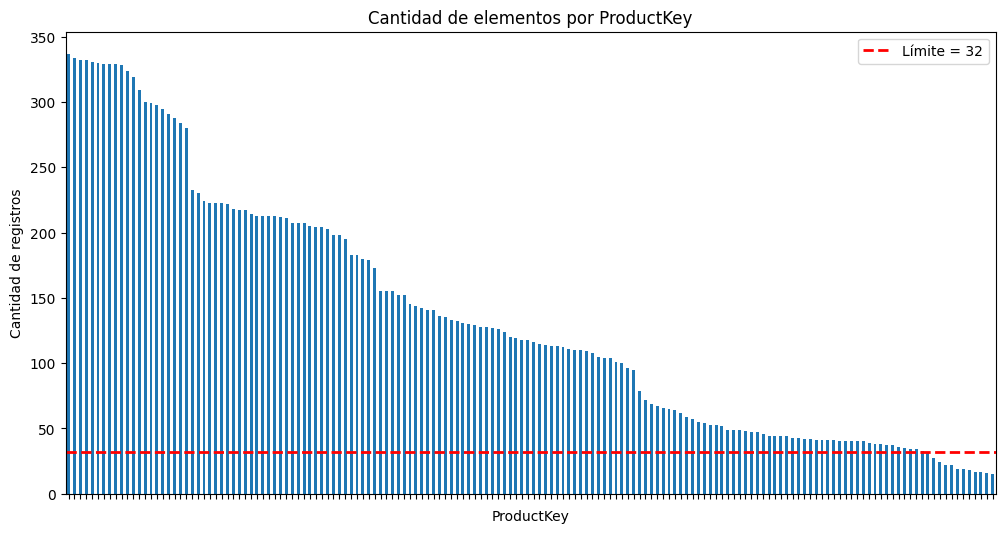

In [11]:
    #Esta parte solo es de control para identificar qué productKeys tienen menos
    #registros de ventas o time_steps
    countProduct = dfg.groupby('ProductKey').size().copy()
    countProduct_sorted = countProduct.sort_values(ascending=False)
    plt.figure(figsize=(12, 6))
    ax = countProduct_sorted.plot(kind='bar')   
    ax.set_xticklabels([''] * len(countProduct_sorted))
    limite = 32
    plt.axhline(y=limite, color='red', linestyle='--', linewidth=2, label=f'Límite = {limite}')
    plt.legend()
    # countProduct.sort_values(ascending=False).plot(kind='bar', figsize=(12, 6))
    plt.xlabel('ProductKey')
    plt.ylabel('Cantidad de registros')
    plt.title('Cantidad de elementos por ProductKey')
    plt.show()

In [12]:
    #En esta parte se detalla quien no cumple con el requisito
    for pk,freq in countProduct_sorted.items():
        if freq < int(PASOS+1):
            print("* ID: ",pk," steps: ",freq," <-")

* ID:  334  steps:  27  <-
* ID:  328  steps:  24  <-
* ID:  326  steps:  22  <-
* ID:  336  steps:  22  <-
* ID:  320  steps:  19  <-
* ID:  330  steps:  19  <-
* ID:  338  steps:  18  <-
* ID:  322  steps:  17  <-
* ID:  332  steps:  17  <-
* ID:  340  steps:  16  <-
* ID:  324  steps:  15  <-


In [13]:
    #Columna que deseamos predecir
    target_col = 'OrderQuantity'

    #Generamos una columna para detectar si hay ventas o no
    isSelledCol = 'IsSelled'

    #generamos una lista de las 'x_features'
    features = list(df.columns.copy())

    #agregamos la nueva columna
    features.append(isSelledCol)

    #obtenemos una copia de todas las columnas
    all_columns = features.copy()

    #eliminamos la columna target
    features.remove(target_col)
    # print(len(features))

### Contexto: tratamniento de datos
Se pretende realizar una serie de procedimientos que permitan mejorar la calidad de las predicciones del modelo, una de las ventajas de LSTM es que a diferencia de modelos convencionales o ARIMA, donde se requieren hacer  procedimientos para ayudar al modelo a mejorar los datos de entrenammiento, con LSTM, puede llegar a tener una mejor comprensión sobre la data. 

In [14]:
'''
En este método se pretende que pueda separar cada ventana deslizantes con las claves del producto
cada productKey tendrá su slidding window con sus propios time_steps 
'''
def split_sequences(df, time_steps, features, target):
    #Separamos en dos grupos, X que contiene todos los features, y Y que contiene la
    X, y = [], []
    for _, grupo in df.groupby('ProductKey'):
        datos = grupo[features].values
        target_vals = grupo[target].values
        for i in range(len(datos) - time_steps):
            X.append(datos[i:i+time_steps])
            y.append(target_vals[i:i+time_steps])
            # y.append(target_vals[i+time_steps])
    return np.array(X), np.array(y)

Lo que se pretende con el algortimo, es obtener la data directamente de la BD, y hacer un tratamiento de datos en el que eliminen valores vacíos y se prepare la data lo más limpio posible para poder brindar un buen entrenamiento para el modelo

In [15]:
def tratamiento_datos(data, columns, features, target_col, new_col, productKeysIDS, dataProduct):
    val = data.copy()
    val = val.reset_index()

    series_modified = []

    for i, group in val.groupby('ProductKey'):

        #obtenemos el productKeyActual
        producK_ID = group['ProductKey'].iloc[0]

        #obtener la fecha inicial
        date_ini = group['Date'].min()

        #obtener la fecha final
        date_last = group['Date'].max()

        #Comvertimos la columna 'Date' a datetime
        group['Date'] = pd.to_datetime(group['Date'], errors='coerce')

        #ordenamos la columna
        group = group.sort_values('Date')
        
        #filtramos y obtenemos los valores únicamente en el rango establecido
        group = group[(group['Date']>= pd.Timestamp(date_ini)) & (group['Date']<=pd.Timestamp(date_last))]

        #seteamos como index
        group_index = group.set_index('Date')

        #Creamos el rango que debería tener lo ya establecido
        days_corrected = pd.date_range(start=date_ini, end=date_last - pd.Timedelta(days=1), freq='D')

        #Reindexamos para poder garantizar continuidad (rellenamos los días faltantes)
        group_reindex = group_index.reindex(days_corrected)

        #Comprobamos, debe haber NaN o NA
        # print(group_reindex)

        #PASO 2: RELLENAR EL RESTO DE COLUMNAS FALTANTES

        group_reindex = group_reindex.reset_index()

        #Rellenar columnas relacionado a la fecha
        group_reindex['YEAR'] = group_reindex['index'].dt.year
        group_reindex['MONTH'] = group_reindex['index'].dt.month
        group_reindex['Day'] = group_reindex['index'].dt.day
        group_reindex['DayOfWeek'] = group_reindex['index'].dt.dayofweek
        group_reindex['IsWeekend'] = group_reindex['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

        #setear index
        group_reindex = group_reindex.set_index('index')

        #COLUMNA TARGET
        group_reindex[target_col] = group_reindex[target_col].fillna(0)

        #Asegurarnos de que es de tipo int
        group_reindex[target_col] = group_reindex[target_col].astype(int)

        #Obtenemos el precio unitario
        precioUNitario = dataProduct[dataProduct['ProductKey'] == producK_ID]['Price'].values[0]

        #obtenemos el envio
        precioEnvio = dataProduct[dataProduct['ProductKey'] == producK_ID]['StandardCost'].values[0]

        #PRECIO UNITARIO
        group_reindex['UnitPrice'] = group_reindex['UnitPrice'].fillna(0.0)

        #DESCUENTO UNITARIO
        group_reindex['UnitPriceDiscountPct'] = group_reindex['UnitPriceDiscountPct'].fillna(0.0)

        #DESCUENTO ACUMULADO
        group_reindex['DiscountAmount'] = group_reindex['DiscountAmount'].fillna(0)

        #PRECIO DE ENVÍO
        group_reindex['ProductStandardCost'] = group_reindex['ProductStandardCost'].fillna(0.0)

        #VENTAS
        group_reindex['SalesAmount'] = group_reindex['SalesAmount'].fillna(0.0)

        #AGREGAR NUEVAMENTE EL PRODUCTKEY
        group_reindex['ProductKey'] = producK_ID

        #INCLUIMOS UNA NUEVA COLUMNA QUE INDIQUE SI HAY VENTAS
        group_reindex[new_col] = group_reindex[target_col].apply(lambda x: 1 if x > 0 else 0)

        # print(group_reindex)

        # Agregar la serie modificada a la lista
        series_modified.append(group_reindex)

    data_modified = pd.concat(series_modified)

    return data_modified

In [17]:
def train_model(x_train, y_train, x_val, y_val, model):
    early_stop = EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)
    history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=PASOS,  validation_data=(x_val, y_val),verbose=2,shuffle=False)

    # Devolver el modelo entrenado y x_test
    return model

In [18]:
#Haremos tratamiento de datos
data_trat = tratamiento_datos(dfg, all_columns,features,target_col,isSelledCol,productKeysIDS,dataProduct)

# Parte 2: Creación del modelo
La idea, es crear un modelo con una arquitectura sugerida por skforecast para poder hacer predicciones


In [19]:
all_columns

['YEAR',
 'MONTH',
 'Day',
 'DayOfWeek',
 'IsWeekend',
 'ProductKey',
 'OrderQuantity',
 'UnitPrice',
 'UnitPriceDiscountPct',
 'DiscountAmount',
 'ProductStandardCost',
 'SalesAmount',
 'IsSelled']

In [ ]:
# Creación del modelo
# ==============================================================================
# Series temporales utilizadas en el entrenamiento. Tiene que incluir la serie a predecir.
all_columns.remove('ProductKey')
series = all_columns
level = [target_col] #serie que se quiere predecir
lags = PASOS #valores pasados a usar en la prediccion
steps = 31 #pasos a futuro a predecir

#Agrupamos mediante productKey
seriesGB = data_trat.groupby('ProductKey')

#Seleccionar las series temporales a usar
data = seriesGB.get_group(214).copy()

data = data.drop(['ProductKey'], axis=1)

# data.reset_index()

# print(data)


#Nos aseguramos de ordenar los datos
# data = data.groupby('ProductKey')

# obtener el total de dias 
total_days = len(data.values)

#datos de entrenamiento
n_days_training = int(total_days*TRAINING_PERCENTAGE)

#datos de validación
n_days_validation = int(total_days-(n_days_training+PASOS))

#datos de testeo
n_days_testing = PASOS

#=========== dividimos la data

#data traininig
data_train = data.iloc[:n_days_training].copy()
data_train = data_train.asfreq('D')

#data validation 
data_validation = data.iloc[n_days_training:n_days_training+n_days_validation].copy()
data_validation = data_validation.asfreq('D')

#data testing
data_testing = data.iloc[-n_days_testing:].copy()
data_testing = data_testing.asfreq('D')

In [21]:
len(data_train.values)

235

In [22]:
len(data_validation.values)

71

In [23]:
len(data_testing.values)

31

# Creamos el modelo

In [26]:
model = create_and_compile_model(
    series=data_train,
    levels=level,
    lags=lags,
    steps=steps,
    recurrent_layer="LSTM",
    recurrent_units=[100,50],
    dense_units=[64,32],
    optimizer=Adam(learning_rate=0.01), 
    loss=MeanSquaredError()
    )
model.summary()

keras version: 3.8.0
Using backend: tensorflow
tensorflow version: 2.18.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 31, 12)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 31, 100)        │        45,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 31)             │         1,023 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 31, 1)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,767 (319.40 KB)

 Trainable params: 81,767 (319.40 KB)

 Non-trainable params: 0 (0.00 B)

### Instancia de Forecaster
cojn esto, se le añade al modelo de regresión todas las funcionalidades necesarias para poder utilizarse en problemas de forecasting

In [27]:
forecaster = ForecasterRnn(
    regressor=model,
    levels=level,
    steps=steps,
    lags=lags,
    transformer_series=MinMaxScaler(),
    fit_kwargs={
        "epochs":10,
        "batch_size":PASOS,
        "series_val": data_validation
    },
)
forecaster

ForecasterRnn 
Regressor: <Functional name=functional, built=True> 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31] 
Transformer for series: MinMaxScaler() 
Window size: 31 
Target series, levels: ['OrderQuantity'] 
Multivariate series (names): None 
Maximum steps predicted: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31] 
Training range: None 
Training index type: None 
Training index frequency: None 
Model parameters: {'name': 'functional', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 31, 12), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer'}, 'registered_name': None, 'name': 'input_layer', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'lstm', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'register

In [28]:
forecaster.fit(data_train)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 243ms/step - loss: 0.5134 - val_loss: 0.2338
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1322 - val_loss: 0.1686
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0760 - val_loss: 0.1218
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0454 - val_loss: 0.0863
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 0.0313 - val_loss: 0.0695
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0308 - val_loss: 0.0717
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0297 - val_loss: 0.0653
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0286 - val_loss: 0.0662
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0289 - val_loss: 0.0659
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0277 - val_loss: 0.0651


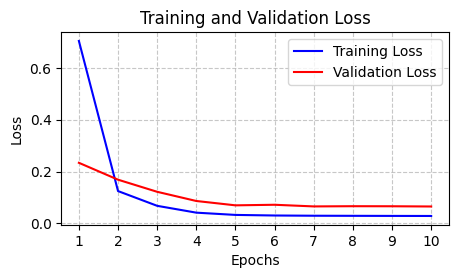

In [29]:
fig, ax = plt.subplots(figsize=(5, 2.5))
forecaster.plot_history(ax=ax)

In [30]:
historyData = set_index_datetime(historyData)

c:\GitHub\pronostico\pronostico\envprediccion\Lib\site-packages\skforecast\deep_learning\_forecaster_rnn.py:768: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5  0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0. ]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.

c:\GitHub\pronostico\pronostico\envprediccion\Lib\site-packages\skforecast\deep_learning\_forecaster_rnn.py:768: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.63333333 0.66666667 0.7        0.73333333 0.76666667 0.8
 0.83333333 0.86666667 0.9        0.93333333 0.96666667 1.
 0.         0.03333333 0.06666667 0.1        0.13333333 0.16666667
 0.2        0.23333333 0.26666667 0.3        0.33333333 0.36666667
 0.4        0.43333333 0.46666667 0.5

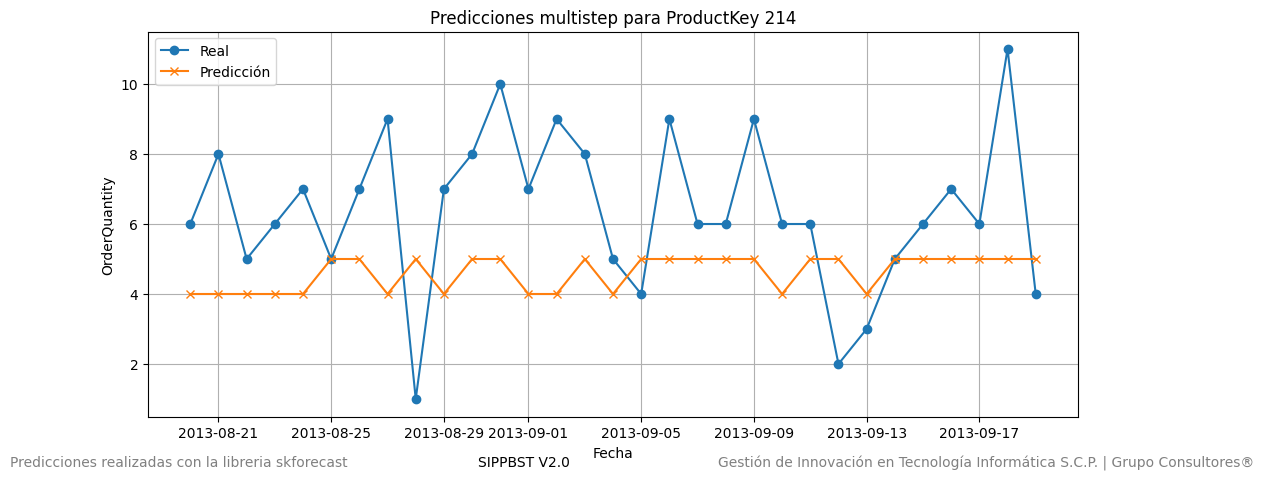

In [31]:
predictions = forecaster.predict()
# Asegurarse de que el índice de historyData sea DatetimeIndex
if not isinstance(historyData.index, pd.DatetimeIndex):
    historyData.index = pd.to_datetime(historyData.index)

# Ajustar historyData para comparar con las predicciones
# Selecciona el mismo rango de fechas que las predicciones
historyData_comp = historyData.loc[predictions.index.min():predictions.index.max()]

# Renombrar columna para graficar fácilmente
historyData_comp = historyData_comp.rename(columns={'TotalVentas': 'OrderQuantity'})
# Graficar las predicciones vs la data histórica real
plt.figure(figsize=(12, 5))
# Graficar valores reales
plt.plot(historyData_comp.index, historyData_comp['OrderQuantity'], label='Real', marker='o')
plt.plot(predictions.index, predictions['pred'].astype(int), label='Predicción', marker='x')
# Graficar predicciones
# plt.plot(predictions.index, predictions['pred'], label='Predicción', marker='x')
plt.title(f'Predicciones multistep para ProductKey {214}')
plt.xlabel('Fecha')
plt.ylabel('OrderQuantity')
plt.figtext(0.01,0.01,"Predicciones realizadas con la libreria skforecast", fontsize=10,color="gray")
plt.figtext(0.60,0.01,"Gestión de Innovación en Tecnología Informática S.C.P. | Grupo Consultores®", fontsize=10, color="gray")
plt.figtext(0.40,0.01, "SIPPBST V2.0")
plt.legend()
plt.grid(True)
plt.show()

In [32]:
predictions

,level,pred
2013-08-20,OrderQuantity,4.572546
2013-08-21,OrderQuantity,4.768807
2013-08-22,OrderQuantity,4.428277
2013-08-23,OrderQuantity,4.952218
2013-08-24,OrderQuantity,4.982726
2013-08-25,OrderQuantity,5.057238
2013-08-26,OrderQuantity,5.085017
2013-08-27,OrderQuantity,4.694920
2013-08-28,OrderQuantity,5.191084
2013-08-29,OrderQuantity,4.654022
